<a href="https://colab.research.google.com/github/bonareri/Cryptocurrency-Price-Prediction-/blob/main/Copy_of_lstm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Understanding the Dataset

In [2]:
#Importing necesseray libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import requests
import joblib
import math
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# import keras_tuner as kt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input

# Set the Seaborn style for all plots
sns.set_style("darkgrid")

In [3]:
# Define the coins and their tickers
COINS = {
    "bitcoin": "BTC-USD",
    "ethereum": "ETH-USD",
    "solana": "SOL-USD",
    "tether": "USDT-USD",  # Added USDT
    "xrp": "XRP-USD",      # Added XRP
    "binancecoin": "BNB-USD" # Added BNB
}

# Function to fetch historical price data
def fetch_crypto_data(coin_id, ticker):
    print(f"Fetching data for {coin_id.upper()}...")

    crypto = yf.Ticker(ticker)
    df = crypto.history(period="max")

    if df.empty:
        print(f"Error: No historical data found for {coin_id}.")
        return None

    # Format data
    df.reset_index(inplace=True)
    df["Date"] = pd.to_datetime(df["Date"]).dt.strftime('%Y-%m-%d')

    # Keep relevant columns
    df = df[["Date", "Close", "High", "Low", "Open", "Volume"]]

    return df

# Main function
def main():
    for coin_id, ticker in COINS.items():
        df = fetch_crypto_data(coin_id, ticker)
        if df is not None:
            filename = f"{coin_id}_prices.csv"
            df.to_csv(filename, index=False)
            print(f"Data saved to {filename}")

if __name__ == "__main__":
    main()


Fetching data for BITCOIN...
Data saved to bitcoin_prices.csv
Fetching data for ETHEREUM...
Data saved to ethereum_prices.csv
Fetching data for SOLANA...
Data saved to solana_prices.csv
Fetching data for TETHER...
Data saved to tether_prices.csv
Fetching data for XRP...
Data saved to xrp_prices.csv
Fetching data for BINANCECOIN...
Data saved to binancecoin_prices.csv


In [4]:
#List of Coins
coins = ["bitcoin", "ethereum", "solana", "tether", "xrp", "binancecoin"]

#Dictionary to store dataframes
crypto_data = {}

#Load csv files dynamically
for coin in coins:
  filename = f"{coin}_prices.csv"
  crypto_data[coin] = pd.read_csv(filename)

In [37]:
for coin, df in crypto_data.items():
  print(f"\n First 5 rows of {coin.capitalize()} data:")
  print(df.tail())


 First 5 rows of Bitcoin data:
                   Close          High           Low          Open  \
Date                                                                 
2025-03-13  81066.703125  84301.695312  79931.851562  83724.921875   
2025-03-14  83969.101562  85263.289062  80797.562500  81066.992188   
2025-03-15  84343.109375  84672.671875  83639.593750  83968.406250   
2025-03-16  82579.687500  85051.601562  82017.906250  84333.320312   
2025-03-17  82761.828125  83818.281250  82571.148438  82571.148438   

                 Volume  
Date                     
2025-03-13  31412940153  
2025-03-14  29588112414  
2025-03-15  13650491277  
2025-03-16  21330270174  
2025-03-17  25662023680  

 First 5 rows of Ethereum data:
                  Close         High          Low         Open       Volume
Date                                                                       
2025-03-13  1862.969604  1919.688232  1823.525391  1909.015381  17977225564
2025-03-14  1909.467529  1945.0914

In [6]:
for coin, df in crypto_data.items():
  print(f"\n Overview of {coin.capitalize()} data:")
  print(df.info())


 Overview of Bitcoin data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3835 entries, 0 to 3834
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3835 non-null   object 
 1   Close   3835 non-null   float64
 2   High    3835 non-null   float64
 3   Low     3835 non-null   float64
 4   Open    3835 non-null   float64
 5   Volume  3835 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 179.9+ KB
None

 Overview of Ethereum data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2686 non-null   object 
 1   Close   2686 non-null   float64
 2   High    2686 non-null   float64
 3   Low     2686 non-null   float64
 4   Open    2686 non-null   float64
 5   Volume  2686 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 126.0+ KB
None



In [7]:
# Create a new dictionary to store cleaned data
cleaned_data = {}

for coin, df in crypto_data.items():
    # Convert 'Date' to datetime format
    df["Date"] = pd.to_datetime(df["Date"])

    # Set 'Date' as the index
    df.set_index("Date", inplace=True)

    # Store cleaned data in a new dictionary to avoid modifying while iterating
    cleaned_data[coin] = df

    # Print DataFrame info separately to avoid returning None
    print(f"\nCleaned {coin.capitalize()} data:")
    df.info()

# Assign the cleaned data back to the original dictionary
crypto_data = cleaned_data


Cleaned Bitcoin data:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3835 entries, 2014-09-17 to 2025-03-17
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3835 non-null   float64
 1   High    3835 non-null   float64
 2   Low     3835 non-null   float64
 3   Open    3835 non-null   float64
 4   Volume  3835 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 179.8 KB

Cleaned Ethereum data:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2686 entries, 2017-11-09 to 2025-03-17
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2686 non-null   float64
 1   High    2686 non-null   float64
 2   Low     2686 non-null   float64
 3   Open    2686 non-null   float64
 4   Volume  2686 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.9 KB

Cleaned Solana data:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1803 ent

## 2. Data Preprocessing

In [8]:
#Dictionary to store close price
crypto_close = {}

#Select only close for each coin
for coin, df in crypto_data.items():
  crypto_close[coin] = df["Close"]

In [9]:
for coin, df in crypto_close.items():
  print(f"\n First 5 rows of {coin.capitalize()} close prices:")
  print(df.head())


 First 5 rows of Bitcoin close prices:
Date
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
Name: Close, dtype: float64

 First 5 rows of Ethereum close prices:
Date
2017-11-09    320.884003
2017-11-10    299.252991
2017-11-11    314.681000
2017-11-12    307.907990
2017-11-13    316.716003
Name: Close, dtype: float64

 First 5 rows of Solana close prices:
Date
2020-04-10    0.951054
2020-04-11    0.776819
2020-04-12    0.882507
2020-04-13    0.777832
2020-04-14    0.661925
Name: Close, dtype: float64

 First 5 rows of Tether close prices:
Date
2017-11-09    1.00818
2017-11-10    1.00601
2017-11-11    1.00899
2017-11-12    1.01247
2017-11-13    1.00935
Name: Close, dtype: float64

 First 5 rows of Xrp close prices:
Date
2017-11-09    0.217488
2017-11-10    0.206483
2017-11-11    0.210430
2017-11-12    0.197339
2017-11-13    0.203442
Name: Close, dtype: float64

 First 5 rows of Binancecoin close prices:
Date
2

## Train Test Split

In [10]:
# Function to split data into 80% training and 20% testing
def split_data(df_close):
    train_size = int(len(df_close) * 0.8)  # 80% of data
    df_train = df_close[:train_size].values  # Training set
    df_test = df_close[train_size:].values   # Testing set
    return df_train, df_test

# Dictionary to store train and test sets for each cryptocurrency
train_test_data = {}

# Assuming crypto_closes is a dictionary where keys are coin names and values are Close price DataFrames
for coin, df_close in crypto_close.items():
    train, test = split_data(df_close)
    train_test_data[coin] = {"train": train, "test": test}

    # Print train-test split info
    print(f"{coin.capitalize()} - Train: {train.shape}, Test: {test.shape}")

Bitcoin - Train: (3068,), Test: (767,)
Ethereum - Train: (2148,), Test: (538,)
Solana - Train: (1442,), Test: (361,)
Tether - Train: (2148,), Test: (538,)
Xrp - Train: (2148,), Test: (538,)
Binancecoin - Train: (2148,), Test: (538,)


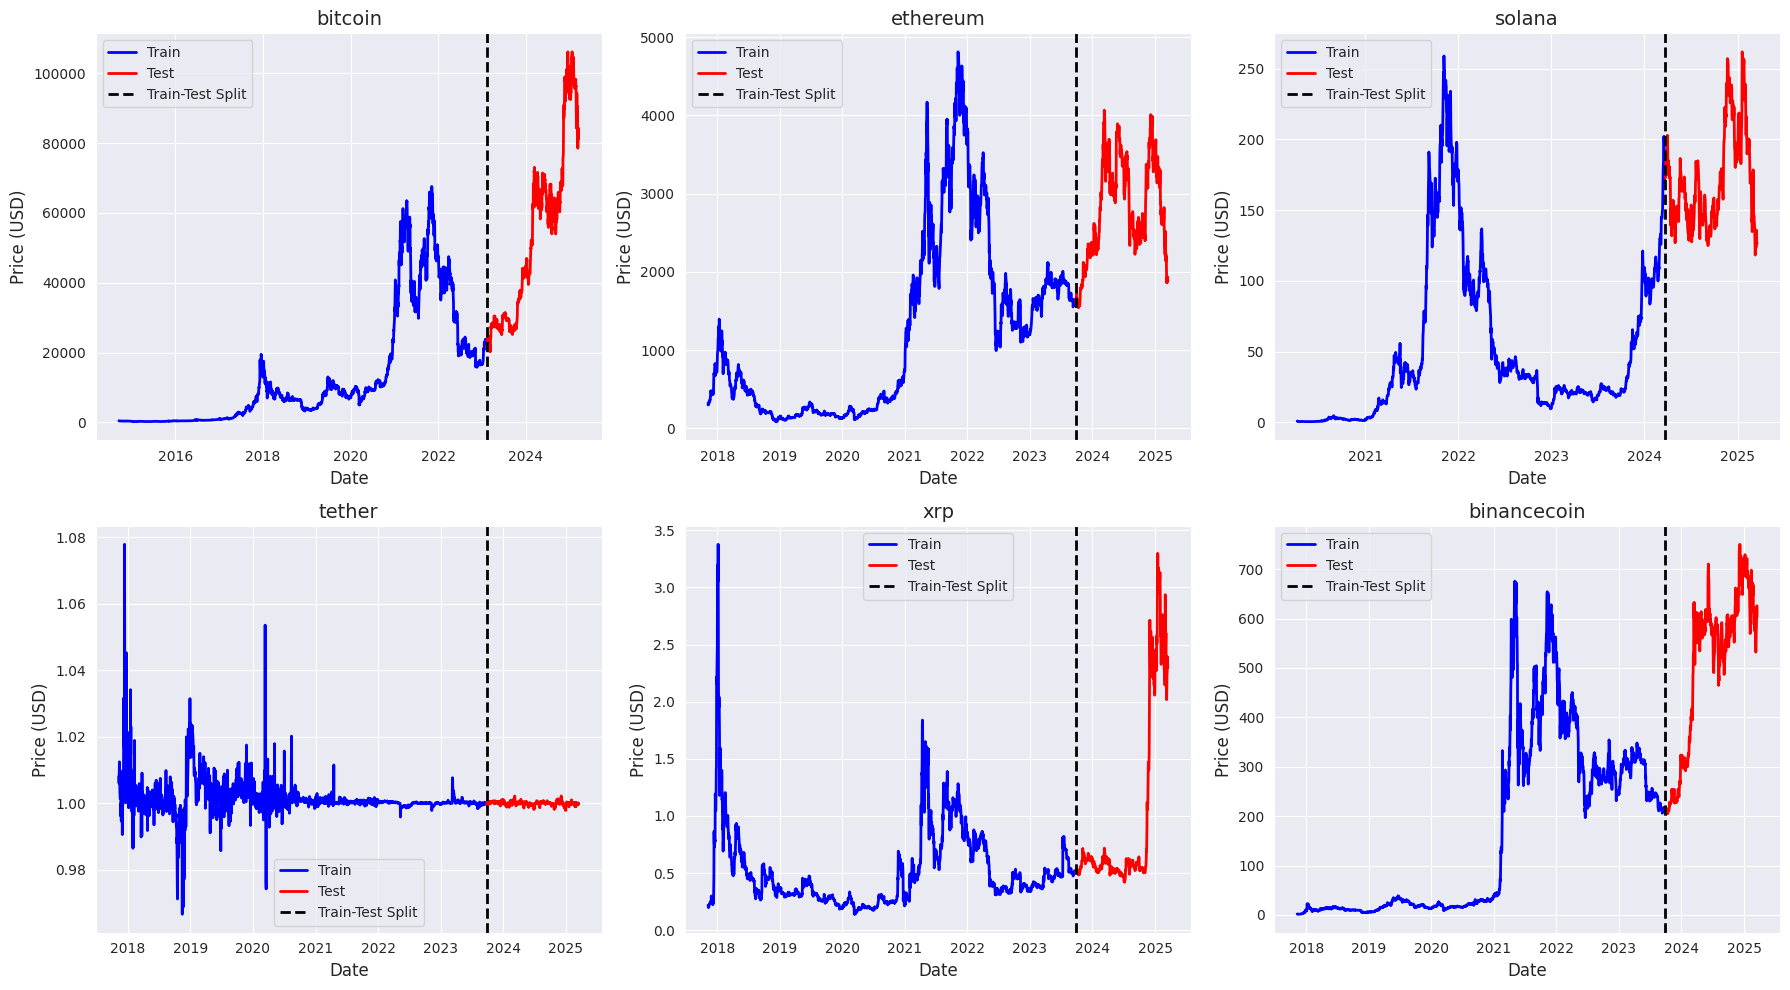

In [11]:
# Extract "Close" price column dynamically from the crypto_data dictionary
crypto_close_data = {coin: df["Close"] for coin, df in crypto_data.items()}

# Determine number of cryptocurrencies
num_coins = len(crypto_close_data)
rows, cols = 3, 3  # 3x3 grid

# Adjust grid if there are fewer than 9 cryptocurrencies
if num_coins < 9:
    rows = int(np.ceil(num_coins / cols))  # Adjust rows dynamically

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows), sharex=False)

# Flatten axes for easy iteration (handles cases where we have less than 9 plots)
axes = axes.flatten()

# Process and plot for each cryptocurrency
for ax, (coin_name, df) in zip(axes, crypto_close_data.items()):
    df_train, df_test = split_data(df)  # Split data
    train_size = len(df_train)  # Get split index

    # Plot training data
    ax.plot(df.index[:train_size], df_train, label='Train', linewidth=2, color='blue')

    # Plot test data
    ax.plot(df.index[train_size:], df_test, label='Test', linewidth=2, color='red')

    # Add vertical split line
    ax.axvline(df.index[train_size], color='black', linestyle='--', linewidth=2, label='Train-Test Split')

    # Set title
    ax.set_title(coin_name, fontsize=14)

    # Set y-label dynamically
    ax.set_ylabel('Price (USD)', fontsize=12)

    # Set x-label for all plots
    ax.set_xlabel('Date', fontsize=12)
    ax.legend(loc='best', fontsize=10)

# Hide any unused subplots (if less than 9 coins)
for i in range(num_coins, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Feature Scaling

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Min Max Scaling of Data post Train-Test Split </h3>
</div>

I ensured that scaling is done only after splitting the data into training and test sets, with each set being scaled separately.

Performing normalization on the data before splitting it is problematic because the scaling process would use the entire dataset — including the test set — as a reference.

This inadvertently causes data leakage from the test set into the training data, leading to unrealistic model performance and potential overfitting. By scaling only after the split, I ensured that the test set remained unseen and untouched during training, which is crucial for accurate model evaluation.










In [12]:
# Function to scale train and test data
def scale_data(train, test):
    scaler = MinMaxScaler(feature_range=(0, 1))  # Initialize a new scaler for each coin
    train = train.reshape(-1, 1)  # Ensure correct shape
    test = test.reshape(-1, 1)

    scaled_train = scaler.fit_transform(train)  # Fit on train, transform train
    scaled_test = scaler.transform(test)  # Transform test (without fitting again)

    return scaled_train, scaled_test, scaler  # Return scaler for potential inverse transformation

# Dictionary to store scaled data
scaled_crypto_data = {}

# Scale each cryptocurrency dataset dynamically
for coin, df_close in crypto_close_data.items():
    train, test = split_data(df_close)  # Split train & test
    scaled_train, scaled_test, scaler = scale_data(train, test)  # Scale data

    scaled_crypto_data[coin] = {
        "train": scaled_train,
        "test": scaled_test,
        "scaler": scaler  # Store scaler for later inverse transforms if needed
    }

# Print shapes and min-max values for confirmation
for coin, data in scaled_crypto_data.items():
    train, test = data["train"], data["test"]
    print(f"{coin} - Scaled Train Shape: {train.shape}, Min: {train.min():.4f}, Max: {train.max():.4f}")
    print(f"{coin} - Scaled Test Shape: {test.shape}, Min: {test.min():.4f}, Max: {test.max():.4f}")
    print("-" * 50)

bitcoin - Scaled Train Shape: (3068, 1), Min: 0.0000, Max: 1.0000
bitcoin - Scaled Test Shape: (767, 1), Min: 0.2969, Max: 1.5725
--------------------------------------------------
ethereum - Scaled Train Shape: (2148, 1), Min: 0.0000, Max: 1.0000
ethereum - Scaled Test Shape: (538, 1), Min: 0.3078, Max: 0.8423
--------------------------------------------------
solana - Scaled Train Shape: (1442, 1), Min: 0.0000, Max: 1.0000
solana - Scaled Test Shape: (361, 1), Min: 0.4558, Max: 1.0114
--------------------------------------------------
tether - Scaled Train Shape: (2148, 1), Min: 0.0000, Max: 1.0000
tether - Scaled Test Shape: (538, 1), Min: 0.2805, Max: 0.3199
--------------------------------------------------
xrp - Scaled Train Shape: (2148, 1), Min: 0.0000, Max: 1.0000
xrp - Scaled Test Shape: (538, 1), Min: 0.0865, Max: 0.9755
--------------------------------------------------
binancecoin - Scaled Train Shape: (2148, 1), Min: 0.0000, Max: 1.0000
binancecoin - Scaled Test Shape: (5

In [13]:
# Save scalers dynamically for all cryptocurrencies
for coin, data in scaled_crypto_data.items():
    scaler_filename = f"{coin.lower()}_scaler.pkl"  # Convert coin name to lowercase for filename
    joblib.dump(data["scaler"], scaler_filename)  # Save scaler
    print(f"Scaler saved successfully for {coin}: {scaler_filename}")

Scaler saved successfully for bitcoin: bitcoin_scaler.pkl
Scaler saved successfully for ethereum: ethereum_scaler.pkl
Scaler saved successfully for solana: solana_scaler.pkl
Scaler saved successfully for tether: tether_scaler.pkl
Scaler saved successfully for xrp: xrp_scaler.pkl
Scaler saved successfully for binancecoin: binancecoin_scaler.pkl


<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Time Series Windowing (Sequence Generation) </h3>
</div>

Since I’m working with **time series data**, I need the LSTM model to learn from **sequential patterns** instead of treating each data point independently.  

Time series windowing transforms raw time series data into **input-output pairs** so that the model can learn from historical data and make accurate future predictions.  

---

**Steps I Took**  

**1️⃣ Defined a Look-Back Window (Sliding Window)**  
I set a **look-back period** (`look_back = 5`), meaning the model will use the **past 5 days' prices** to predict the **next day's price**.  
This helps capture short-term trends in the data.

 Example:  


For example, given a sequence like [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], the data will be split into samples like:

```python

Input 				| Output
1, 2, 3, 4, 5 		6
2, 3, 4, 5, 6 		7
3, 4, 5, 6, 7 		8

```
**2️⃣ Created Input (X) and Output (y) Pairs**  
I looped through the **scaled dataset** and extracted:  
- **X** → The past `look_back` days (input sequence).  
- **y** → The next day's value (target label).  



In [14]:
# Function to create sequences for multi-step forecasting
def create_sequences(dataset, look_back=5, future_days=30):
    """
    Generates input-output pairs for LSTM.

    Args:
        dataset (numpy.ndarray): Scaled dataset.
        look_back (int): Number of past days to use as input.
        future_days (int): Number of future days to predict.

    Returns:
        tuple: Feature sequences (X) and multi-step target values (y).
    """
    X, y = [], []
    for i in range(len(dataset) - look_back - future_days):
        X.append(dataset[i:(i + look_back), 0])  # Past `look_back` values
        y.append(dataset[i + look_back:i + look_back + future_days, 0])  # Next `future_days` values

    return np.array(X).reshape(-1, look_back, 1), np.array(y)  # ✅ Ensure correct shape

# Define look_back period (e.g., 5 days) and prediction period (30 days)
look_back = 5
future_days = 30

# Dictionary to store sequences for each cryptocurrency
train_sequences, test_sequences = {}, {}

# Process each cryptocurrency dynamically
for coin, data in scaled_crypto_data.items():
    train_sequences[coin] = create_sequences(data["train"], look_back, future_days)
    test_sequences[coin] = create_sequences(data["test"], look_back, future_days)

# Extract sequences dynamically
for coin, (trainX, trainY) in train_sequences.items():
    testX, testY = test_sequences[coin]

    print(f"{coin} - TrainX shape: {trainX.shape}, TrainY shape: {trainY.shape}")
    print(f"{coin} - TestX shape: {testX.shape}, TestY shape: {testY.shape}")
    print("-" * 50)

bitcoin - TrainX shape: (3033, 5, 1), TrainY shape: (3033, 30)
bitcoin - TestX shape: (732, 5, 1), TestY shape: (732, 30)
--------------------------------------------------
ethereum - TrainX shape: (2113, 5, 1), TrainY shape: (2113, 30)
ethereum - TestX shape: (503, 5, 1), TestY shape: (503, 30)
--------------------------------------------------
solana - TrainX shape: (1407, 5, 1), TrainY shape: (1407, 30)
solana - TestX shape: (326, 5, 1), TestY shape: (326, 30)
--------------------------------------------------
tether - TrainX shape: (2113, 5, 1), TrainY shape: (2113, 30)
tether - TestX shape: (503, 5, 1), TestY shape: (503, 30)
--------------------------------------------------
xrp - TrainX shape: (2113, 5, 1), TrainY shape: (2113, 30)
xrp - TestX shape: (503, 5, 1), TestY shape: (503, 30)
--------------------------------------------------
binancecoin - TrainX shape: (2113, 5, 1), TrainY shape: (2113, 30)
binancecoin - TestX shape: (503, 5, 1), TestY shape: (503, 30)
---------------

### Reshaping Data (LSTM Format)

- Convert trainX & testX into (samples, time steps, features) format for LSTM.
- **Samples**: The total number of data points (`len(dataX)`).
- **Time steps**: The width of the sliding window (e.g., 5 in this case).
- **Features**: The number of features per time step. For example, in predicting Bitcoin price, the feature is 1 (the price at that time step).
- LSTM expects 3D inputs.

---

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> LSTM (Long Short-Term Memory) Mechanism </h3>
</div>

LSTM is a type of recurrent neural network (RNN) designed to overcome the vanishing gradient problem. It uses internal gates to regulate information flow, enabling effective backpropagation through time (BPTT).

#### LSTM Layers in Keras
- LSTM layers can be created using the `LSTM()` class in Keras.
- Each LSTM cell has an internal **cell state** (`c`) and a **hidden state** (`h`).
- The `input_shape` for LSTM is `(timesteps, n_features)`, e.g., `(95000, 360)`.
- Keras LSTM expects inputs in the shape: `(n_examples, n_timesteps, n_features)`.

#### `return_sequences=True`
- Enables stacking of multiple LSTM layers.
- Ensures the second LSTM layer receives a compatible n-dimensional sequence input.
- Outputs one value per time step when set to `True`.

#### Why Increase LSTM Depth?
- **Enhances feature abstraction**: Similar to deep learning, deeper LSTMs recombine learned representations to capture complex patterns.
- **Efficient training**: Deeper networks often require fewer neurons and train faster.
- **Temporal abstraction**: Stacking LSTM layers allows models to process sequences at different time scales.

Stacked LSTMs have become a standard approach for complex sequence prediction tasks.


In [21]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Stop training when validation loss stops improving
    patience=10,  # Wait 10 epochs before stopping
    restore_best_weights=True,  # Restore the best model weights
    verbose=1  # Print updates when early stopping is triggered
)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),  # Explicit input layer

        LSTM(units=50, return_sequences=True, activation='tanh',
             kernel_regularizer=l2(0.001)),
        Dropout(0.3),

        LSTM(units=40, return_sequences=False, activation='tanh',
             kernel_regularizer=l2(0.001)),
        Dropout(0.3),

        Dense(units=60, activation='relu'),  # Increased neurons
        Dense(units=1)  # ✅ Output a single value per step
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

    return model

### Prepare Storage for Models & Histories



In [23]:
models = {}
histories = {}

### Train Models for Each Cryptocurrency

In [24]:
for coin, (trainX, trainY) in train_sequences.items():
    testX, testY = test_sequences[coin]

    print(f"\n🚀 Training LSTM Model for {coin}...\n")

    # Step 1: Build the model
    model = build_lstm_model(input_shape=(trainX.shape[1], 1))

    # Step 2: Train the model
    history = model.fit(
        trainX, trainY,
        epochs=100,
        batch_size=64,
        validation_data=(testX, testY),
        callbacks=[early_stopping],
        verbose=1
    )

    # Step 3: Store trained model & history
    models[coin] = model
    histories[coin] = history

    print(f"\n✅ Finished training {coin} model.\n" + "-" * 50)


🚀 Training LSTM Model for bitcoin...

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1356 - val_loss: 0.1027
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0571 - val_loss: 0.0510
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0397 - val_loss: 0.0416
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0287 - val_loss: 0.0326
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0208 - val_loss: 0.0387
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0154 - val_loss: 0.0228
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0119 - val_loss: 0.0227
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100 - val_loss: 0.0182
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - val_loss: 0.0146
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0072 - val_loss: 0.0200
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0061 - val_loss: 0.0165
Epoch 12/100
48/48 ━━

In [25]:
# Save trained models for each cryptocurrency
print("\n💾 Saving Trained LSTM Models...\n" + "=" * 60)

for coin, model in models.items():
    model_filename = f"{coin.lower()}_lstm_model.keras"
    model.save(model_filename)
    print(f" {coin} LSTM model saved successfully as '{model_filename}'.")

print("\n🎉 All models saved successfully!\n" + "=" * 60)


💾 Saving Trained LSTM Models...
 bitcoin LSTM model saved successfully as 'bitcoin_lstm_model.keras'.
 ethereum LSTM model saved successfully as 'ethereum_lstm_model.keras'.
 solana LSTM model saved successfully as 'solana_lstm_model.keras'.
 tether LSTM model saved successfully as 'tether_lstm_model.keras'.
 xrp LSTM model saved successfully as 'xrp_lstm_model.keras'.
 binancecoin LSTM model saved successfully as 'binancecoin_lstm_model.keras'.

🎉 All models saved successfully!


## Model Evaluation

### Evaluate Model on Test Data

In [26]:
# Evaluate each model's performance on its respective test data
print("\n Evaluating Model Performance...\n" + "=" * 60)

evaluation_results = {}

for coin, model in models.items():
    testX, testY = test_sequences[coin]  # Get test data for the coin

    # Ensure testX has the correct shape (samples, timesteps, features)
    if len(testX.shape) == 2:  # (samples, timesteps) → missing features dimension
        testX = testX.reshape(testX.shape[0], testX.shape[1], 1)

    print(f"\n🔍 Evaluating {coin} model on test data...\n")
    test_loss = model.evaluate(testX, testY, verbose=1)

    evaluation_results[coin] = test_loss  # Store results for later reference
    print(f" {coin} Test Loss (MSE): {test_loss:.6f}\n" + "-" * 50)

# Display final summary of test losses
print("\n📈 Final Test Loss Summary:")
for coin, loss in evaluation_results.items():
    print(f"🔹 {coin}: {loss:.6f}")

print("\n Model evaluation completed!\n" + "=" * 60)


 Evaluating Model Performance...

🔍 Evaluating bitcoin model on test data...

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086
 bitcoin Test Loss (MSE): 0.014552
--------------------------------------------------

🔍 Evaluating ethereum model on test data...

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052
 ethereum Test Loss (MSE): 0.006713
--------------------------------------------------

🔍 Evaluating solana model on test data...

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0107 
 solana Test Loss (MSE): 0.013976
--------------------------------------------------

🔍 Evaluating tether model on test data...

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2486e-04 
 tether Test Loss (MSE): 0.000141
--------------------------------------------------

🔍 Evaluating xrp model on test data...

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 
 xrp Test Loss (MSE): 0.023657
--------------------------------------------------

🔍 Evaluating binancecoin model on test data

### Plot Training & Validation Loss Curves

In [ ]:
print(histories.keys())

dict_keys(['bitcoin', 'ethereum', 'solana', 'tether', 'xrp', 'binancecoin'])


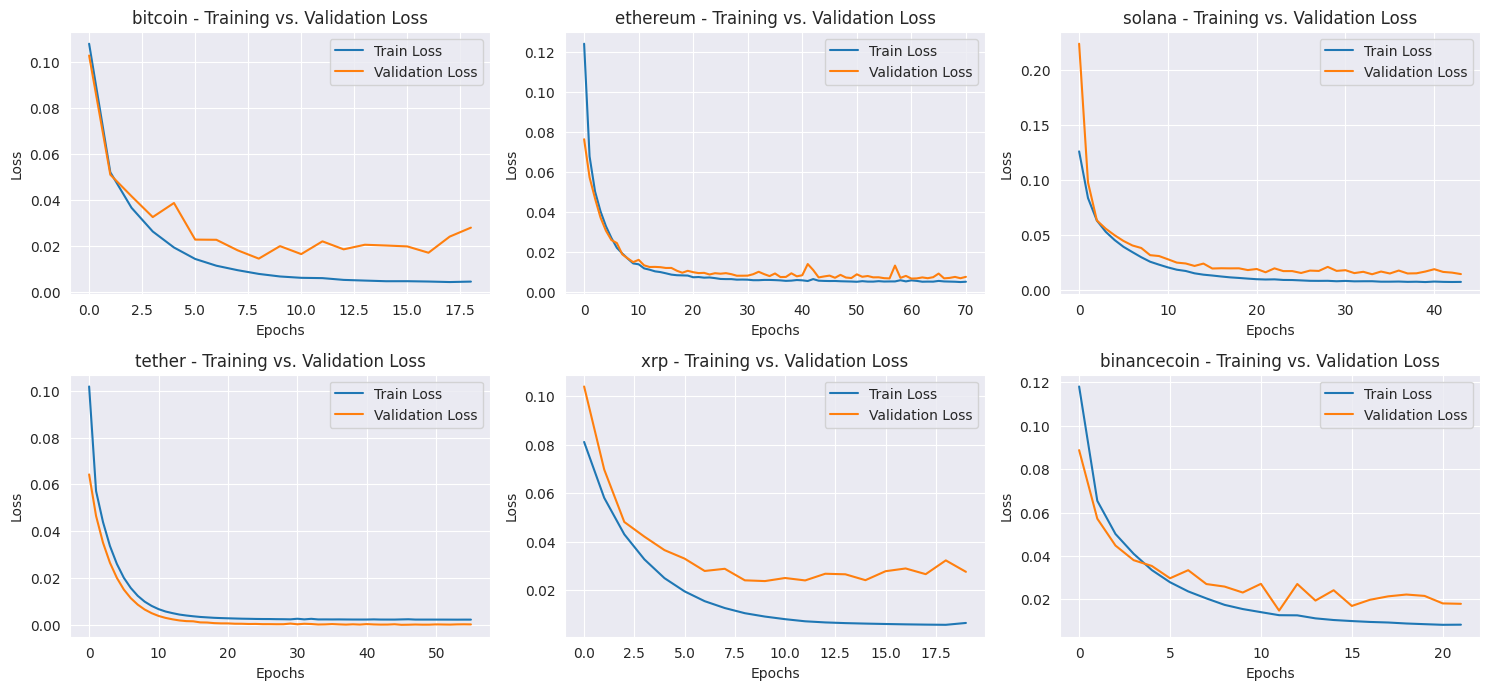

In [27]:
# List of cryptocurrencies to plot
coins = ['bitcoin', 'ethereum', 'solana', 'tether', 'xrp', 'binancecoin']

# Determine subplot grid size
rows, cols = 3, 3  # 3 rows, 3 columns

plt.figure(figsize=(15, 10))  # Adjust figure size for better visibility

for i, coin in enumerate(coins, 1):
    plt.subplot(rows, cols, i)  # Arrange subplots in a 3x3 grid
    plt.plot(histories[coin].history['loss'], label='Train Loss')
    plt.plot(histories[coin].history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{coin} - Training vs. Validation Loss')
    plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Rolling Forecast for Each Cryptocurrency

In [36]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

def rolling_forecast(model, input_seq, scaler, n_steps=30):
    """
    Generates rolling predictions for n_steps into the future.

    Parameters:
        model: Trained LSTM model
        input_seq: Last available sequence from test data
        scaler: Corresponding scaler for inverse transformation
        n_steps: Number of future steps to predict (default: 30)

    Returns:
        np.array: Forecasted values (inverse transformed)
    """
    predictions = []
    current_input = input_seq.copy()

    for _ in range(n_steps):
        current_input_reshaped = current_input.reshape(1, -1, 1)  # Reshape for LSTM
        next_pred = model.predict(current_input_reshaped)[0, 0]  # Predict next step

        predictions.append(next_pred)  # Store raw prediction

        # Update input sequence (shift left and append new prediction)
        current_input = np.append(current_input[1:], next_pred)

    # Convert predictions back to actual values
    predictions_actual = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

    return predictions_actual

# Store results
forecast_results = {}

# Define forecast horizon
n_steps = 30

for coin, model in models.items():
    last_sequence = test_sequences[coin][0][-1]  # Use last sequence from test data
    scaler = scalers[coin]  # Get corresponding scaler

    print(f"\n📈 Running rolling forecast for {coin}...\n")
    forecast = rolling_forecast(model, last_sequence, scaler, n_steps=n_steps)

    # Generate dates for the forecast
    forecast_dates = [datetime.today() + timedelta(days=i) for i in range(n_steps)]

    # Store results in a DataFrame
    forecast_df = pd.DataFrame({
    "Date": [date.strftime("%Y-%m-%d") for date in forecast_dates],  # Format to YYYY-MM-DD
    "Predicted Price": forecast
    })

    forecast_results[coin] = forecast_df  # Save results

    print(f"✅ Finished rolling forecast for {coin}\n" + "-" * 50)

# Display Bitcoin predictions as an example
print("\nBitcoin Predictions for the Next 30 Days:")
print(forecast_results["bitcoin"])


📈 Running rolling forecast for bitcoin...

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━

### Performance Metrics (RMSE & MAE)

In [40]:
import pandas as pd

# Create DataFrames for actual and predicted values
actual_df = actual_bitcoin_prices.reset_index()[["Date", "Close"]]  # Reset index to access Date
actual_df.rename(columns={"Close": "Actual Price"}, inplace=True)

predicted_df = bitcoin_predictions_df  # Already has columns: Date, Predicted Price

# Merge DataFrames on Date
combined_df = pd.merge(actual_df, predicted_df, on="Date", how="inner")

# Display first few rows
print(combined_df.head())


NameError: name 'actual_bitcoin_prices' is not defined

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Drop NaN values (since actual data might be missing for future dates)
valid_df = combined_df.dropna()

# Extract actual and predicted prices
actual_prices = valid_df["Actual Price"].values
predicted_prices = valid_df["Predicted Price"].values

# Compute RMSE
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

# Compute MAE
mae = mean_absolute_error(actual_prices, predicted_prices)

# Print the results
print(f"🔹 RMSE: {rmse:.2f}")
print(f"🔹 MAE: {mae:.2f}")

NameError: name 'combined_df' is not defined

### Plot Actual vs. Predicted Values

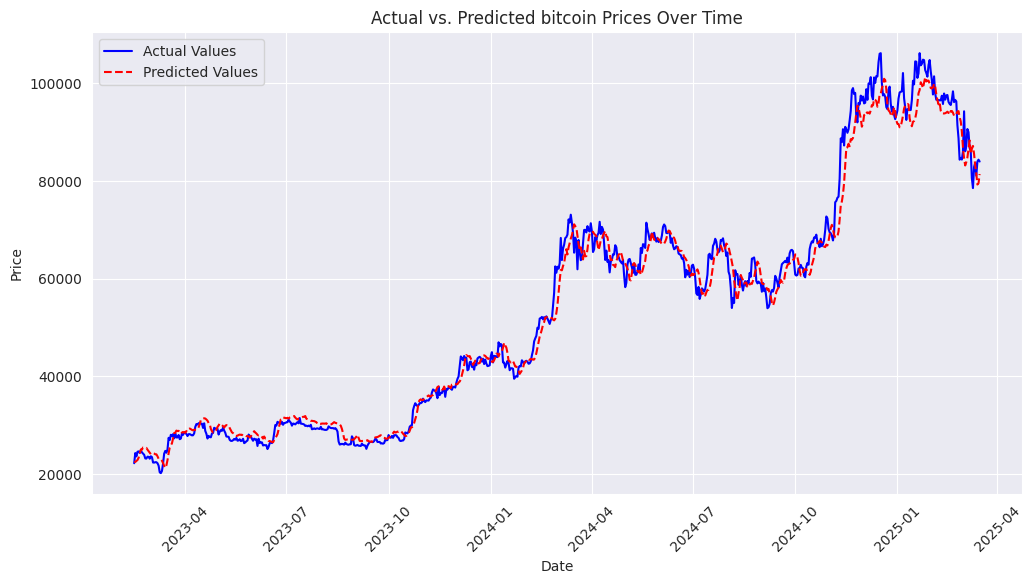

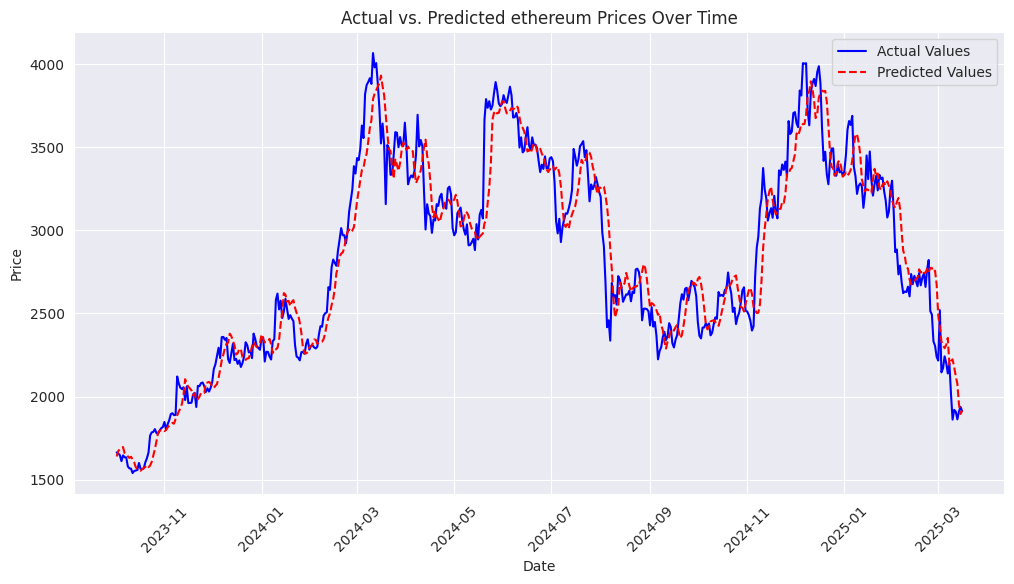

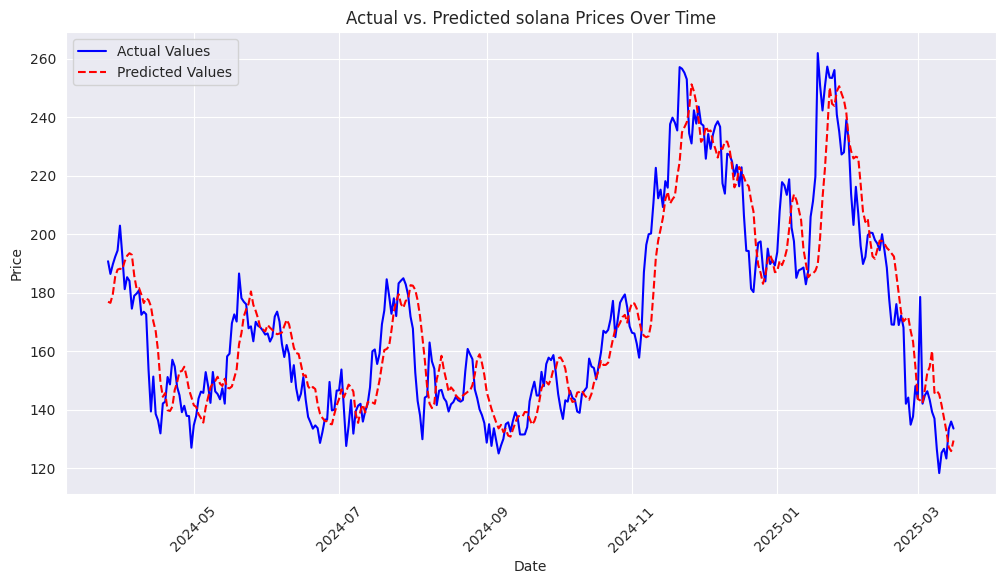

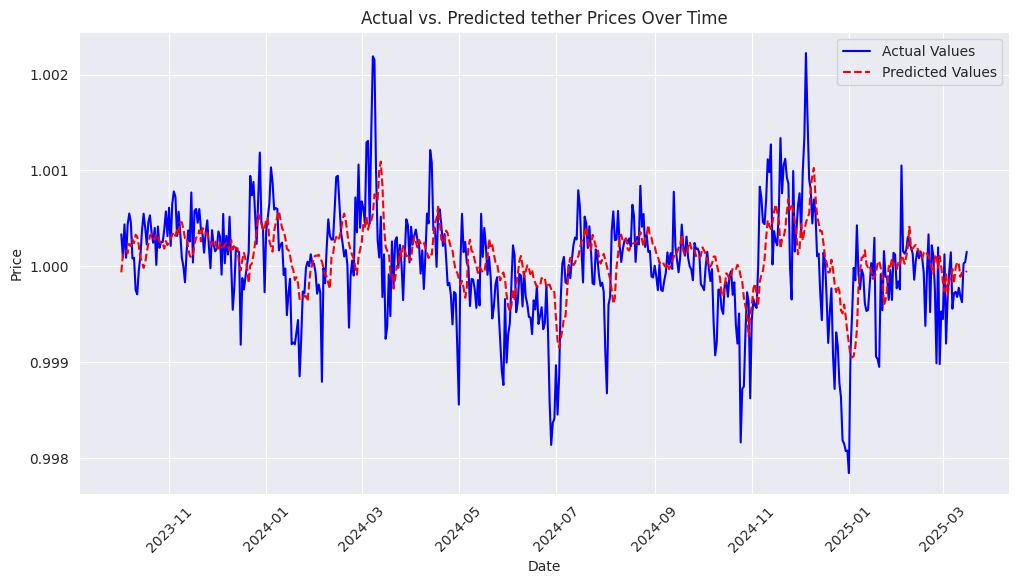

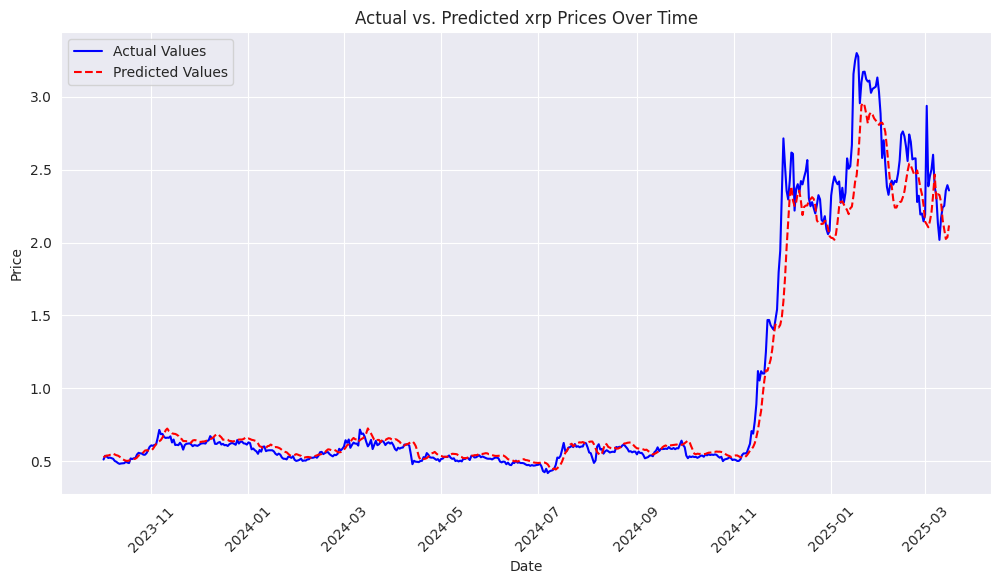

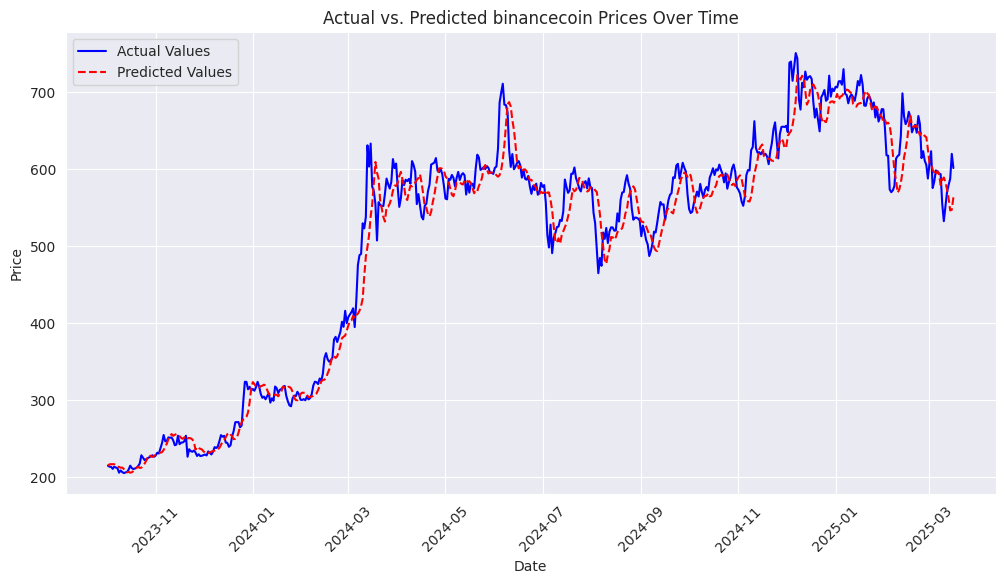

In [ ]:
coins = ["bitcoin", "ethereum", "solana", "tether", "xrp", "binancecoin"]

# Plot actual vs. predicted values for each cryptocurrency
for coin in coins:
    plt.figure(figsize=(12, 6))

    # Get actual and predicted values
    actual = actual_values[coin]
    predicted = predictions[coin]

    # Get corresponding date indexes
    dates = crypto_close[coin].index

    # Plot actual values
    plt.plot(dates[-len(actual):], actual,
             label="Actual Values", color='blue', linestyle='solid')

    # Plot predicted values
    plt.plot(dates[-len(predicted):], predicted,
             label="Predicted Values", color='red', linestyle='dashed')

    # Graph labels
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"Actual vs. Predicted {coin} Prices Over Time")
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

    # Show the plot
    plt.show()